<div class="alert alert-info">

**A Note to the Reader**:

This section requires some basic familiarity with Calculus; the reader will be expected to know what it means to take the derivative of a function, and to have some familiarity with [Liebnitz notation](https://en.wikipedia.org/wiki/Leibniz%27s_notation) for representing derivatives.

</div>

# Automatic Differentiation


(Full disclosure: I created MyGrad, which we will be discussing here. Like PLYMI, MyGrad is a completely free and open-source educational resource.)

This section is not about the essentials of NumPy, rather it is about a 3rd party library, [MyGrad](https://github.com/rsokl/MyGrad), that adds a new capability to NumPy. It adds automatic differentiation: the ability to algorithmically evaluate derivatives of functions.

Automatic differentiation (a.k.a autodiff) is an important technology for scientific computing and machine learning, it enables us to measure rates of change (or "cause and effect") through our code via the derivatives of the mathematical functions that our code computes.
Autodiff is proving to be so crucial to advancements in STEM-computing that it ought to be introduced to audiences early in their numerical computing journeys.
This is the motivation for including this section in PLYMI's NumPy module.

An automatic differentiation library provides its users with a suite of mathematical functions and tools that are specially designed: any mathematical computation that you perform with this library can be used to also compute the *derivatives* of that result. 
To help paint a picture of this, consider the following psuedocode where we use an autodiff library to compute $f(x) = \sqrt{x}$ evaluated at $x=1$, as well as the derivative $\mathrm{d}f/\mathrm{d}x = 1/(2\sqrt{x})$, also evaluated at $x=1$.

```python
# pseudocode illustrating autodiff in action
>>> from autodiff_libray import sqrt, derivative

>>> x = 1.0
>>> f = sqrt(x)
>>> df_dx = derivative(f, x)

>>> f, df_dx
(1.0, 0.5)
```

See that we did not need to know or derive the fact that $\mathrm{d}f/\mathrm{d}x = 1/(2\sqrt{x})$ -- the autodiff library does this for us!
This is what sets `autodiff_libray.sqrt` apart from `math.sqrt` from Python's standard library.


Presently, some of the most popular Python-centric autodiff libraries include [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/), and [JAX](https://jax.readthedocs.io/en/latest/jax.numpy.html). Among these "industrial-grade" autodiff libraries, JAX strives provide the most NumPy-like experience. [MyGrad](https://github.com/rsokl/MyGrad) takes this one step further, and provides true drop-in automatic differentiation to NumPy.


## Introduction to MyGrad


Install MyGrad into your Python environment. Open your terminal, activate your desired Python environment, and run the following command.

```shell
pip install mygrad
```


Let's jump right in with a simple example of using MyGrad to evaluate the derivative of a function at a specific point. 
We'll take our function to be $f(x)=x^2$, and compute its instantaneous slope at $x=5$, i.e. $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=5}$.
The derivative of this function is $\frac{\mathrm{d}f}{\mathrm{d}x}=2x$, thus $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=5} = 10$.
Let's reproduce this result via auto-differentiation using MyGrad.

We begin by creating a `mygrad.Tensor`. 
This is MyGrad's analog to [numpy's ndarray](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/IntroducingTheNDarray.html). 
[MyGrad's tensor](https://mygrad.readthedocs.io/en/latest/tensor.html) behaves just like  NumPy's array in just about every way that you can think of, e.g. it supports multi-dimensional indexing, reshaping, and vectorized operations with broadcasting semantics, but it is also capable of facilitating automatic differentiation.
This tensor will *store the point(s) at which we wish to evaluate our function and its derivative*.

```python
# `mygrad.Tensor` behaves like `numpy.array` but it supports auto-diff
>>> import mygrad as mg
>>> x = mg.tensor(5.0)
>>> x
Tensor(5.0)
```

We can then pass this tensor directly into NumPy's mathematical functions.
In this example, our function is $f(x)=x^2$.
We can compute this just as we would with NumPy: either with `x ** 2` or with `numpy.square(x)`.

```python
# evaluating f(5)
>>> fx = x ** 2
>>> fx
Tensor(25.0)
```

`fx` stores the value of our function -- as a `Tensor` -- at the given evaluation points, which in this case is $f(5)=5^2=25$.

Now we can use MyGrad to evaluate the derivative of $f(x)$ at $x=5$.
Invoking `fx.backward()` instructs MyGrad to evaluate the derivative of `fx` *for each variable that* `fx` *depends on* -- the derivatives of multivariable functions can also be computed.
In this case, $x$ is the only such variable.

```python
# trigger auto-differentiation of `fx` with respect to
# all of the variables that it depends on
>>> fx.backward()
```

The value of $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=5}$ is stored in the attribute `x.grad`.

```python
# accessing df/dx @ x=5
>>> x.grad
array(10.)
```
As expected, MyGrad computes the appropriate value for the evaluated derivative: $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=5}=2 \times 5=10$.
Note that all `Tensor` instances have a `grad` attribute, but prior to invoking `fx.backward()`, `x.grad` would have simply returned `None`.


It is important to reiterate that MyGrad *never gives us the actual function* $\frac{\mathrm{d}f}{\mathrm{d}x}$; it only computes the derivative evaluated at a specific input $x=10$.

### MyGrad Adds "Drop-In" AutoDiff to NumPy



MyGrad's functions are intentionally designed to mirror NumPy's functions almost exactly.
In fact, for all of the NumPy functions that MyGrad mirrors, we can pass a tensor to a NumPy function and it will be "coerced" into returning a tensor instead of a NumPy array – thus we can differentiate through NumPy functions!

```python
# showing off "drop-in" autodiff through NumPy functions
>>> import numpy as np

>>> x = mg.tensor(3.0)
>>> y = np.square(x)  # note that we are using a numpy function here!
>>> y  # y is a tensor, not a numpy array
Tensor(9.)

>>> y.backward()  # compute derivatives of y
>>> x.grad  # stores dy/dx @ x=3
array(6.)
```

How does this work?
MyGrad's tensor is able to [tell NumPy's function to actually call a MyGrad function](https://numpy.org/neps/nep-0018-array-function-protocol.html).
That is, the expression

```python
np.square(a_mygrad_tensor)
```

*actually* calls

```python
mg.square(a_mygrad_tensor)
```

under the hood.
Not only is this convenient, but it also means that you can take a complex function that is written in terms of numpy functions and pass a tensor through it so that you can differentiate that function!

```python
from some_library import complicated_numpy_function
x = mg.tensor(...)
out_tensor = complicated_numpy_function(x)
out_tensor.backward() # compute d(complicated_numpy_function) / dx !
```

## Vectorized Auto-Differentiation

Like NumPy's array, MyGrad's tensor supports [vectorized operations](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html), allowing us to evaluate the derivative of a function at multiple points simultaneously.
Let's again take the function $f(x)=x^2$, which has the derivative $\frac{\mathrm{d}f}{\mathrm{d}x}=2x$.
Now, instead of passing in a single number to `Tensor`, we can pass in a list of values corresponding to all the points at which we want the compute the derivative.
We can then find the instantaneous slope of our function at these points, just as before. First we will pass `x` into our function of interest, namely $f(x)=x^2$.

```python
# using vectorized operations to evaluate a function
# at multiple locations
>>> x = mg.tensor([2.0, -4.0, 1.0, 3.0])
>>> fx = x ** 2
>>> fx
Tensor([ 4., 16.,  1.,  9.])
```

Here MyGrad vectorizes the operation, performing it element-wise:

\begin{equation}
f\big([2,\, -4,\, 1,\, 3]\big) =  \big[f(2),\, f(-4),\, f(1),\, f(3)\big].
\end{equation}

We can elegantly exploit this vectorization to find the derivative of $f(x)$ evaluated at each point in `x` by invoking `fx.backward()`.
This will trigger the vectorized computation

\begin{equation}
\bigg[\frac{\mathrm{d}f}{\mathrm{d}x}\bigg|_{x=2},\: \frac{\mathrm{d}f}{\mathrm{d}x}\bigg|_{x=-4},\: \frac{\mathrm{d}f}{\mathrm{d}x}\bigg|_{x=1},\: \frac{\mathrm{d}f}{\mathrm{d}x}\bigg|_{x=3} \bigg],
\end{equation}

which will be stored in `x.grad`.
It is important to recognize that `x.grad[i]` stores the derivative of `fx` evaluated at `x[i]`.

```python
# Trigger vectorized auto-differentiation
# Computes the instantaneous slope of
# f(x) = x ** 2 at 2, 4, 1, and 3
>>> fx.backward()
>>> x.grad # df/dx @ x = 2, -4, 1, and 3, respectively
array([ 4., -8.,  2.,  6.])
```

As expected, MyGrad finds the appropriate value for the derivative evaluated at each respective element in `x`.

<div class="alert alert-info">

## Visualizing the Derivative

The following code block demonstrates how easy it is to visualize a function's derivative by using MyGrad.
Note MyGrad's `Tensor` stores a NumPy-array of its data, which can be accessed via the `.data` attribute.
Any time a library needs to be passed a NumPy array, you can access this array from a tensor through this attribute.

Study the plot displayed below: notice that the derivative is always $0$ when the function has a horizontal slope, and that the derivative takes on a positive value wherever the parent function has a positive slope. 

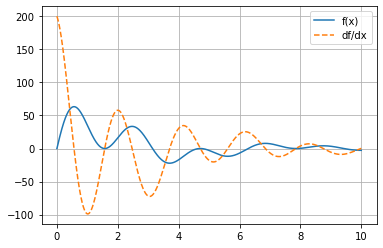

In [1]:
import mygrad as mg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return np.sin(2 * x) * np.cos(x) * np.exp(-x / 3) * 100

def plot_func_and_deriv(x, func):
    fig, ax = plt.subplots()
    
    x = mg.tensor(x)
    y = func(x)  # compute f(x)
    y.backward() # compute df/dx
    
    # plot f(x) vs x
    ax.plot(x.data, y.data, label="f(x)")
    
    # plot df/dx vs x
    ax.plot(x.data, x.grad, ls="--", label="df/dx")
    ax.grid(True)
    ax.legend()
    return fig, ax

# We will plot f(x) and df/dx on the domain
# [0, 10] using 10,000 evenly-spaced points 
x = mg.linspace(0, 10, 10000)

plot_func_and_deriv(x, f);

## Seek and Derive

Computers equipped with automatic differentiation libraries can make short work of derivatives that are well-beyond the reach of mere mortals.
Take the pathological function
\begin{equation}
f(x)=e^{(\arctan(82x^3+\ln(x)))}\sqrt{25x^{\frac{1}{22930}}+39e^{\frac{2}{x}}-\sin(x)},
\end{equation}

the derivative of which would be miserable to do by hand.
Thankfully we can have MyGrad compute the derivative at a collection of points for us, just as we did before.

```python
# Tensor containing the values x = 1, 2, ..., 10
>>> x = mg.arange(1.0, 11.0)

# Evaluated function at points x = 1, 2, ..., 10
>>> fx = np.exp(np.arctan(82 * x ** 3 + np.log(x)))
>>> fx *= np.sqrt(25 * x ** (1 / 22930) + 39 * np.exp(2 / x) - np.sin(x))

>>> fx.backward()

>>> x.grad  # df/dx evaluated at x = 1, 2, ..., 10
array([-7.44764313e+01, -1.09475963e+01, -3.78281290e+00, -1.86451297e+00,
       -1.29207692e+00, -1.07197583e+00, -7.90459238e-01, -3.96212428e-01,
       -8.16203127e-02, -3.17648949e-02])
```

Even though it would be a pain to differentiate $f(x)$ by hand, MyGrad can handle taking the derivative with no problems.
To find the derivative of a complex function, we simply must chain together the relevant functions and sit back – MyGrad will handle the rest.
It accomplishes this feat by dutifully applying the chain rule over and over, using a simple algorithm called "back-propagation".
The authors of MyGrad had to write down the symbolic derivative for each elementary function (e.g., $e^x$, $\sqrt{x}$, $\arctan(x)$, etc.), but MyGrad's code is responsible for systematically carrying out the chain rule to evaluate derivatives of arbitrarily-complex compositions of these functions.

<div class="alert alert-info">

**Reading Comprehension: Auto-differentiation**:
    
Using MyGrad, compute the derivatives of the following functions.
Have MyGrad evaluate the derivatives on the interval $[-2,4]$ at $30$ evenly spaced points using `mygrad.linspace`.
Additionally, plot these functions and their derivatives on the same domains, but using more densely-spaced points 
    
* $f(x)=\frac{e^x}{e^x+1}$
* $f(x)=e^{-\frac{(x-1)^2}{10}}$
* $f(x)=\frac{\sin(x)}{x}-x^2$
* $f(x)=9\sqrt{1+\frac{x^2}{9}}-9$

</div>

## Applying Automatic Differentiation: Solving Optimization Problems


We are now familiar with what automatic differentiation is and what it does, but *why* is it so useful?
One of the "killer applications" of autodiff libraries is that they help us solve challenging numerical optimization problems.
These problems often read as: suppose we have some bounded, finite function $f(x)$; find the value of $x$ that *minimizes* $f(x)$.
That is, the "optimum" that we want to find is the value $x_\mathrm{min}$ such that $f(x_\mathrm{min}) \leq f(x)$ for all other $x$.


How does automatic differentiation help us to solve such a problem? The derivative of a function evaluated at some $x_o$ tells us the slope of the function -- whether it is decreasing or increasing -- at $x_o$.
This is certainly useful information for helping us search for $x_\mathrm{min}$: always look in the direction of decreasing slope, until the slope goes to $0$.

We start our search for $x_{\mathrm{min}}$ by picking a random starting for value for $x_o$, use the autodiff library to compute $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=x_{o}}$ and then use that information to "step" $x_o$ in the direction that "descends" $f(x)$. We repeat this process until we see that $\frac{\mathrm{d}f}{\mathrm{d}x}\big|_{x=x_{o}} \approx 0$.
It must be noted that this approach towards finding $x_\mathrm{min}$ is highly limited; saddle-points can stop us in our tracks, and we will only be able to find *local* minima with this strategy. Nonetheless, it is still very useful!

Let's take a simple example.
We'll choose the function $f(x) = (x-8)^2$ and the starting point $x=-1.5$.
As we search for $x_\mathrm{min}$ we don't want to make our updates to $x_o$
too big, so we will scale our updates by a factor of $3/10$ (the value of which is chosen somewhat haphazardly here).

```python
# Performing gradient descent on f(x) = (x - 8) ** 2
x = mg.Tensor(-1.5)
step_scale = 0.3
num_steps = 10
print(x)

for step_cnt in range(num_steps):
    f = (x - 8.0) ** 2  # evaluate f(xo)
    f.backward()  # compute df/dx @ xo
    x = x - step_scale * x.grad  # update xo in direction opposite of df/dx @ xo
    print(x)
```
```
Tensor(-1.5)
Tensor(4.2)
Tensor(6.48)
Tensor(7.392)
Tensor(7.7568)
Tensor(7.90272)
Tensor(7.961088)
Tensor(7.9844352)
Tensor(7.99377408)
Tensor(7.99750963)
Tensor(7.99900385)
```

Success! Our autodiff-driven optimization algorithm successfully guides us near the minimum $x_\mathrm{min}=8$.

This simple algorithm is known as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) (a gradient is a collection of derivatives for a multi-variable function), and it is a powerful technique for finding local minima in differentiable functions.
As we saw in the preceding section, autodiff libraries enable use to search for local optima of *very* complex functions, and we can often work with functions that will depend on *hundreds, thousands, or even many millions of variables*.
In such cases, we have no hope of simply plotting the function and literally looking for the minimum, nor do we have any chance of writing down the function's derivative by hand.
Fortunately, we have autodiff and gradient descent in our toolkit.

For those who have heard of neural networks and deep learning: autodiff libraries, used in conjunction with gradient descent, is how we often "teach" a neural network to perform a task. We use gradient descent to find the optimal parameter values of the neural network; the values are found such that they *minimize the average number of mistakes* the neural makes when performing training tasks.

This section has just scratched the surface of automatic differentiation. Reading about the different algorithms for performing automatic differentiation ([forward-mode differentation, back-propagation, and beyond](https://en.wikipedia.org/wiki/Automatic_differentiation#The_chain_rule,_forward_and_reverse_accumulation)), about computing higher-order derivatives, and about the [interesting advances in programming languages' approaches to automatic differentiation](https://fluxml.ai/blog/2019/02/07/what-is-differentiable-programming.html) are all fascinating and worthwhile endeavors. 
If you plan to take a course in differential calculus soon, see if you can incorporate autodiff into your coursework!


## Reading Comprehension Exercise Solutions

**Auto-differentiation: Solution**

In [2]:
def f(x):
    return mg.exp(x) / (mg.exp(x) + 1)


x = mg.linspace(-2, 4, 30)
fx = f(x)
fx.backward()
x.grad

array([0.10499359, 0.12233146, 0.14104602, 0.16067062, 0.18052503,
       0.19972311, 0.21721938, 0.2319002 , 0.24271321, 0.2488147 ,
       0.24970297, 0.24530344, 0.23598166, 0.22248044, 0.20579899,
       0.18704635, 0.167303  , 0.14751557, 0.12843546, 0.11059942,
       0.09434168, 0.07982542, 0.0670819 , 0.05604927, 0.04660642,
       0.03859972, 0.03186277, 0.02622978, 0.02154407, 0.01766271])

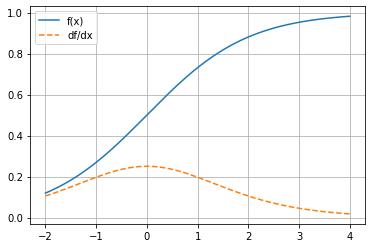

In [3]:
plot_func_and_deriv(mg.linspace(-2, 4, 1000), f);

In [4]:
def f(x):
    return mg.exp(-(x - 1) ** 2 / 10)


x = mg.linspace(-2, 4, 30)
fx = f(x)
fx.backward()
x.grad

array([ 0.2439418 ,  0.25603855,  0.2649823 ,  0.27016051,  0.2710269 ,
        0.26713309,  0.25815818,  0.24393438,  0.22446663,  0.19994461,
        0.1707458 ,  0.13742886,  0.10071733,  0.06147402,  0.02066753,
       -0.02066753, -0.06147402, -0.10071733, -0.13742886, -0.1707458 ,
       -0.19994461, -0.22446663, -0.24393438, -0.25815818, -0.26713309,
       -0.2710269 , -0.27016051, -0.2649823 , -0.25603855, -0.2439418 ])

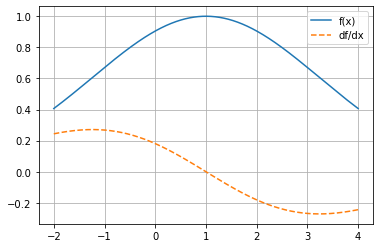

In [5]:
plot_func_and_deriv(mg.linspace(-2, 4, 1000), f);

In [6]:
def f(x):
    return mg.sinc(x) - x ** 2


x = mg.linspace(-2, 4, 30)
fx = f(x)
fx.backward()
x.grad

array([ 3.5       ,  3.08231909,  2.88185434,  2.87154224,  2.9562879 ,
        2.99759486,  2.85459947,  2.42860038,  1.69642019,  0.72117344,
       -0.36375522, -1.39291332, -2.21717854, -2.74695958, -2.97654586,
       -2.98223402, -2.89552134, -2.86072901, -2.99117993, -3.3379685 ,
       -3.88059233, -4.54104218, -5.21509113, -5.80917978, -6.27018042,
       -6.59861798, -6.84225739, -7.07396645, -7.36293903, -7.75      ])

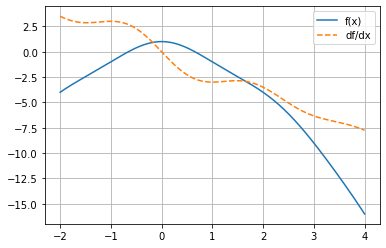

In [7]:
plot_func_and_deriv(mg.linspace(-2, 4, 1000), f);

In [8]:
def f(x):
    return 9 * mg.sqrt(1 + x ** 2 / 9) - 9


x = mg.linspace(-2, 4, 30)
fx = f(x)
fx.backward()
x.grad

array([-1.66410059, -1.53913231, -1.40226235, -1.25319963, -1.09198696,
       -0.91909001, -0.73547021, -0.54262408, -0.34257202, -0.13778548,
        0.0689473 ,  0.27470313,  0.47662691,  0.6721239 ,  0.85901208,
        1.03561618,  1.20079858,  1.35393517,  1.49485163,  1.62373797,
        1.74105718,  1.8474593 ,  1.9437076 ,  2.03061964,  2.10902314,
        2.1797249 ,  2.24349055,  2.30103263,  2.35300473,  2.4       ])

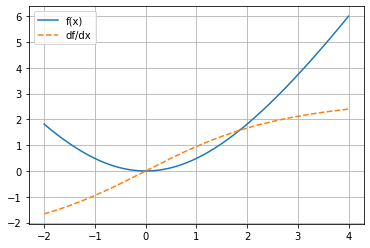

In [9]:
plot_func_and_deriv(mg.linspace(-2, 4, 1000), f);